In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from model_funcs import *

In [2]:
dt = 0.001
B = 6.5*10**-3   # temperature lapse rate in troposphere in K/m
R = 287   # ideal gas constant in J/(kg.K)
g = 9.80665  # gravity at sea level in m/s2
T0 = 288.15   # standard air temperature in K
P0 = 101.325   # standard air pressure in kPa
pi = math.pi
ft = 3.2884  # ft/m

In [3]:
################## DATA FRAME ##################
#datafile = '../Fullscale21.csv'
datafile = '../Data/Trunc_Fullscale1.csv'
fields = ['Timestamp', 'Pres',
  'Roll', 'Pitch', 'Yaw',
  'LinearAccelNed X', 'LinearAccelNed Y', 'LinearAccelNed Z',
  ]

df = pd.read_csv(datafile, skipinitialspace=True, usecols=fields)

In [4]:
imu_t = df['Timestamp'].values
imu_t = imu_t - imu_t[0]
imu_N = len(imu_t)
imu_ax = df['LinearAccelNed X'].values
imu_ay = df['LinearAccelNed Y'].values
imu_az = df['LinearAccelNed Z'].values * -1
imu_pres = df['Pres']

################## INIT VECTORS  ##################
imu_vx, imu_vy, imu_vz, imu_x, imu_y, imu_z = (np.zeros((imu_N)), np.zeros((imu_N)), 
                                               np.zeros((imu_N)), np.zeros((imu_N)), 
                                               np.zeros((imu_N)), np.zeros((imu_N)))

################## Find velocity and position  ##################
for i in range(imu_N-1):
    imu_vz[i+1] = imu_vz[i] + imu_az[i]*(imu_t[i+1] - imu_t[i])
    imu_z[i+1] = imu_z[i] + imu_vz[i]*(imu_t[i+1] - imu_t[i])
    
    imu_vx[i+1] = imu_vx[i] + imu_ax[i]*(imu_t[i+1] - imu_t[i])
    imu_x[i+1] = imu_x[i] + imu_vx[i]*(imu_t[i+1] - imu_t[i])
    
    imu_vy[i+1] = imu_vy[i] + imu_ay[i]*(imu_t[i+1] - imu_t[i])
    imu_y[i+1] = imu_y[i] + imu_vy[i]*(imu_t[i+1] - imu_t[i])
    
################## Find alt  ##################
def nasa_pres(P, P0, T0, R, B, g):
    imu_temp = T0*(P/P0)**(R*B/g)
    imu_alt = (T0 - imu_temp)/B
    return imu_alt

vec_NASA_pres = np.vectorize(nasa_pres)
imu_alt = vec_NASA_pres(imu_pres, P0, T0, R, B, g)   # * ft + 600
imu_alt = imu_alt - imu_alt[imu_N-1]
imu_alt = [val if val > 0 else 0 for val in imu_alt]

In [5]:
imu_start_time, imu_end_time, takeoff_time, a_1 = find_peak_and_wait(np.array(imu_ax), imu_t)

trunc_signal = imu_ax[imu_start_time:imu_end_time]
trunc_time = imu_t[imu_start_time:imu_end_time]

smoothed_signal = calc_moving_avg(trunc_signal, 25, trunc_time, dynamic_window=False, dynamic_n_timing=140, dynamic_n=80)

w_0 = 0.5*max(abs(np.array(smoothed_signal)))*(trunc_time[-1] - trunc_time[0])
K = a_1/w_0**2 

In [6]:
if max(np.array(smoothed_signal)) > 0.1:
    max_accel = max(np.array(smoothed_signal))
    flip = 1
else:
    max_accel = max(abs(np.array(smoothed_signal)))
    flip = -1
w_0 = 0.5*max_accel*(trunc_time[-1] - trunc_time[0])

w_0

6.508457080000041

In [7]:
## DERIVED PARAMETERS
w_0_mph = w_0/0.44704
z_0 = max(imu_alt) # apogee altitude in m

################## CONSTANT WIND PROFILE & AIR DENSITY  ##################
wind_profile_x = np.zeros((imu_N))
density_profile = np.zeros((imu_N))

z0 = max(imu_alt) # apogee altitude in m

for i in range(imu_N):
    T = T0 - B * imu_alt[i]
    P = P0 * 1000 * (T/T0)**(g/(R*B))
    density_profile[i] = P/(R*T)
    if imu_alt[i] < 2:
        wind_profile_x[i] = w_0*((2/z0)**(1/7))
    else:
        wind_profile_x[i] = w_0*((imu_alt[i]/z0)**(1/7))

In [9]:
x1, t1 = model1(imu_t[imu_start_time], imu_t, imu_ax, imu_vx, imu_x, dt, a_1, imu_alt, wind_profile_x, density_profile, K)
x2, t2 = model2(imu_t, dt, imu_alt, wind_profile_x, density_profile, K)

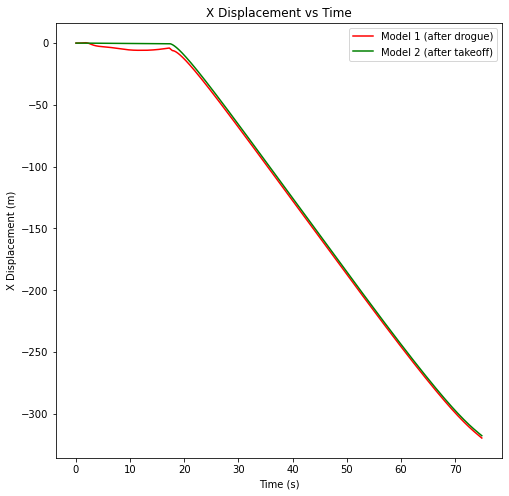

In [10]:
fig1 = plt.figure(1, figsize=(8,8))
ax = plt.subplot(111)
ax.plot(t1, x1*flip, color='red', label='Model 1 (after drogue)')
ax.plot(t2, x2*flip, color='green', label='Model 2 (after takeoff)')
ax.set_title("X Displacement vs Time")  # 'interpreter','latex', 'FontSize', 16
ax.set_xlabel("Time (s)")  # 'interpreter','latex', 'FontSize', 16
ax.set_ylabel("X Displacement (m)")  # 'interpreter','latex', 'FontSize', 16
ax.legend()
plt.show()